In [1]:
# 📘 Detecting Misleading Amazon Reviews (Fraud Analytics Project)

# ===========================
# 📝 Executive Summary – Fraud Analytics Case Study
# ===========================

"""
Project Title: Detecting Misleading Amazon Reviews (Fraud Analytics Project)

Risk:
Online platforms face a significant fraud risk from misleading or manipulated customer reviews. Such anomalies can distort product reputation,
misguide consumers, and expose companies to reputational and financial risk.

Audit Approach:
- Applied Natural Language Processing (NLP) and VADER sentiment analysis to evaluate consistency across review title, text, and star rating.
- Treated inconsistencies as control exceptions and flagged them as potential fraud indicators.
- Developed and tested multiple machine learning classifiers using structured audit evidence (TF-IDF features).

Key Findings:
- A portion of reviews show mismatched sentiment vs. rating, raising potential red flags.
- Among classifiers, the best-performing model demonstrated the highest accuracy in detecting suspicious reviews.

Audit Recommendation:
- Deploy the fraud detection model as a continuous audit control to monitor reviews in real time.
- Integrate results into fraud risk dashboards for management reporting.
- Extend framework to support internal audit testing, compliance monitoring, and anomaly detection across other customer feedback datasets.
"""


'\nProject Title: Detecting Misleading Amazon Reviews (Fraud Analytics Project)\n\nRisk:\nOnline platforms face a significant fraud risk from misleading or manipulated customer reviews. Such anomalies can distort product reputation,\nmisguide consumers, and expose companies to reputational and financial risk.\n\nAudit Approach:\n- Applied Natural Language Processing (NLP) and VADER sentiment analysis to evaluate consistency across review title, text, and star rating.\n- Treated inconsistencies as control exceptions and flagged them as potential fraud indicators.\n- Developed and tested multiple machine learning classifiers using structured audit evidence (TF-IDF features).\n\nKey Findings:\n- A portion of reviews show mismatched sentiment vs. rating, raising potential red flags.\n- Among classifiers, the best-performing model demonstrated the highest accuracy in detecting suspicious reviews.\n\nAudit Recommendation:\n- Deploy the fraud detection model as a continuous audit control to m

In [3]:
# 1. Audit Risk Assessment – Understanding the Dataset
import pandas as pd

# Load your dataset (update path as needed)
df = pd.read_csv("amazon-reviews-org.csv.csv")

print("Dataset Snapshot:")
print(df.head())

print("\nAudit Evidence Sources (Columns):")
print(df.columns.tolist())


Dataset Snapshot:
         reviewId                                       reviewDate  \
0  R1TWIP923TUPRV  Reviewed in the United States on August 8, 2021   
1  R1N5I12682L3YY  Reviewed in the United States on August 2, 2021   
2  R1S3UGVIPYX6W5   Reviewed in the United States on July 27, 2021   
3  R3RELGNNBTGZ2V   Reviewed in the United States on July 26, 2021   
4   RLQ9C5R2KYV67   Reviewed in the United States on July 24, 2021   

             mainDepartment          subDepartment  \
0  Beauty and Personal Care  Foot,Hand & Nail Care   
1  Beauty and Personal Care  Foot,Hand & Nail Care   
2  Beauty and Personal Care  Foot,Hand & Nail Care   
3  Beauty and Personal Care  Foot,Hand & Nail Care   
4  Beauty and Personal Care  Foot,Hand & Nail Care   

                                         productName  \
0  Hard As Hoof Nail Strengthening Cream with Coc...   
1  Hard As Hoof Nail Strengthening Cream with Coc...   
2  Hard As Hoof Nail Strengthening Cream with Coc...   
3  Hard As H

In [5]:
# 2. Data Preparation & Controls Setup
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = "".join([ch for ch in text if ch not in string.punctuation])
        tokens = [w for w in text.split() if w not in stop_words]
        return " ".join(tokens)
    else:
        return ""

df["clean_text"] = df["reviewText"].apply(preprocess_text)
df["clean_title"] = df["reviewTitle"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaelm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# 3. Sentiment Analysis (VADER) as Control Testing
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    if not text:
        return "Neutral"
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_title"] = df["clean_title"].apply(get_sentiment_label)
df["sentiment_text"] = df["clean_text"].apply(get_sentiment_label)

# Control Test: Check for sentiment consistency between title & text
df["sentiment_consistent"] = df["sentiment_title"] == df["sentiment_text"]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gaelm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# 4. Fraud Indicator Labeling – Flagging Suspicious Reviews
def rating_to_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df["rating_sentiment"] = df["reviewStar"].apply(rating_to_sentiment)

# Fraud Rule: If sentiment is consistent but mismatches rating → suspicious
def fraud_flag(row):
    if row["sentiment_consistent"]:
        if row["sentiment_text"] != row["rating_sentiment"]:
            return "Untrustworthy"
    return "Trustworthy"

df["fraud_flag"] = df.apply(fraud_flag, axis=1)

print(df["fraud_flag"].value_counts())


fraud_flag
Trustworthy      58486
Untrustworthy    14014
Name: count, dtype: int64


In [11]:
# 5. Feature Engineering for Fraud Detection
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["fraud_flag"].apply(lambda x: 1 if x == "Untrustworthy" else 0)  # 1 = Fraud, 0 = Trustworthy


In [12]:
# 6. Model Testing & Fraud Analytics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": LinearSVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

audit_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    # Reframe metrics in audit terms
    audit_results.append({
        "Model": name,
        "Control Exception Rate (1-Accuracy)": round(1-accuracy, 3),
        "Fraud Detection Sensitivity (Recall)": round(recall, 3),
        "False Positive Risk (1-Precision)": round(1-precision, 3),
        "F1 Score": round(f1, 3)
    })

audit_report = pd.DataFrame(audit_results)
print("\n📊 Audit Findings Table:")
print(audit_report)



📊 Audit Findings Table:
                 Model  Control Exception Rate (1-Accuracy)  \
0          Naïve Bayes                                0.193   
1  Logistic Regression                                0.196   
2        Random Forest                                0.197   
3                  SVM                                0.202   
4    Gradient Boosting                                0.193   

   Fraud Detection Sensitivity (Recall)  False Positive Risk (1-Precision)  \
0                                 0.002                              0.000   
1                                 0.017                              0.634   
2                                 0.078                              0.546   
3                                 0.034                              0.697   
4                                 0.004                              0.091   

   F1 Score  
0     0.004  
1     0.033  
2     0.134  
3     0.061  
4     0.007  


C:\Users\gaelm\AppData\Local\Temp\ipykernel_34304\2312456530.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0,0,1,0.95])


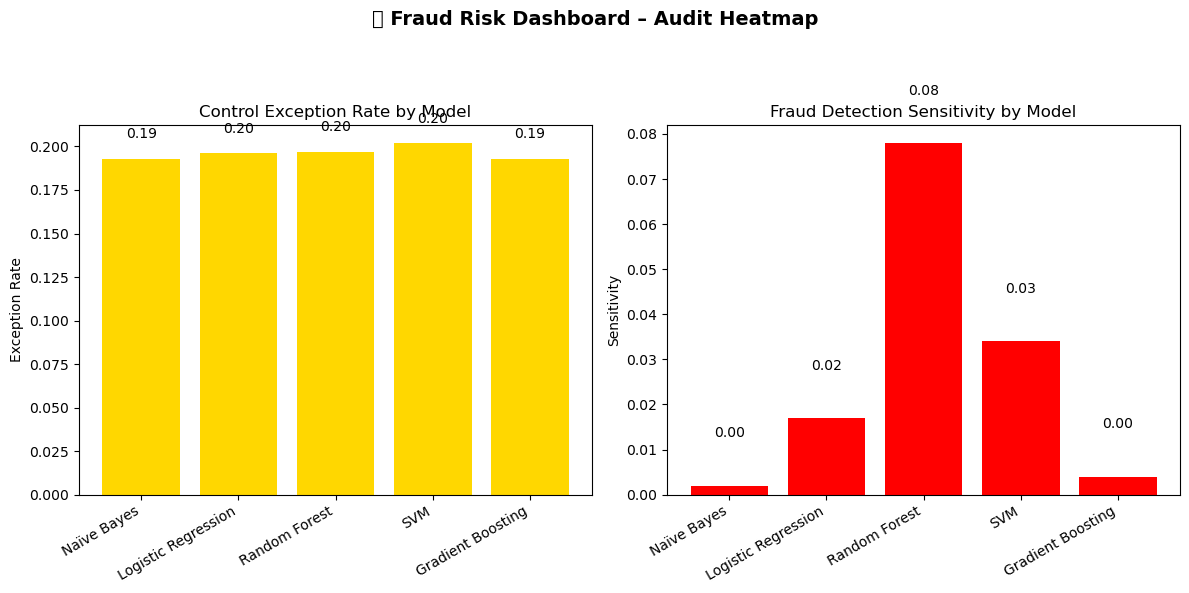

In [14]:
# 8. Fraud Risk Dashboard – Audit Visualization with Traffic Light Heatmap
import matplotlib.pyplot as plt
import numpy as np

# Define thresholds for coloring
def risk_color_exception(rate):
    if rate < 0.15:   # good control
        return "green"
    elif rate < 0.30: # moderate risk
        return "gold"
    else:             # high risk
        return "red"

def risk_color_sensitivity(sens):
    if sens > 0.80:   # strong fraud detection
        return "green"
    elif sens > 0.60: # acceptable
        return "gold"
    else:             # weak fraud detection
        return "red"

exception_colors = [risk_color_exception(r) for r in audit_report["Control Exception Rate (1-Accuracy)"]]
sensitivity_colors = [risk_color_sensitivity(r) for r in audit_report["Fraud Detection Sensitivity (Recall)"]]

plt.figure(figsize=(12,6))

# Plot Exception Rate
plt.subplot(1,2,1)
bars1 = plt.bar(audit_report["Model"], audit_report["Control Exception Rate (1-Accuracy)"], color=exception_colors)
plt.title("Control Exception Rate by Model")
plt.ylabel("Exception Rate")
plt.xticks(rotation=30, ha="right")

# Add labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha="center", va="bottom")

# Plot Fraud Detection Sensitivity
plt.subplot(1,2,2)
bars2 = plt.bar(audit_report["Model"], audit_report["Fraud Detection Sensitivity (Recall)"], color=sensitivity_colors)
plt.title("Fraud Detection Sensitivity by Model")
plt.ylabel("Sensitivity")
plt.xticks(rotation=30, ha="right")

# Add labels
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha="center", va="bottom")

plt.suptitle("📊 Fraud Risk Dashboard – Audit Heatmap", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
